# deeptrack.augmentations

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/3-advanced-topics/DTAT329_augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeptrack  # Uncomment if running on Colab/Kaggle.

This advanced tutorial introduces the module deeptrack.augmentations.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## 1. What is an Augmentation?

Augmentations are instances of the abstract class `Feature` and serve to decrease the average simulation time by altering the input image several times before performing additional expensive computation. This is particularly useful when data generation is computationally costly, as it allows for multiple variations of an image to be produced without re-evaluating the underlying feature. For example, `FlipDiagonal` is an augmentation that returns both the input image and the transposed image before recomputing the input.

All augmentations take a parent feature as their first input. To leverage the caching and reuse properties, the parent feature can be wrapped in `dt.Reuse`. Upon initialization, dt.Reuse resolves a set of images from the parent feature and stores them. Each time the augmentation is updated, an image is randomly selected from this stored set. The `uses` parameter controls how many times a cached output is used before the feature is re-evaluated, while the `storage` parameter determines how many instances of the feature’s output are cached at once. Once the cache reaches this size, older instances are discarded. When the augmentation is resolved, it modifies the selected image using the `.get()` method.

## 2. Example of an Augmentation

Below is a simple implementation of the feature `FlipLR`, which flips images left-to-right with a specified probability (`p`).

In [3]:
from deeptrack.augmentations import Augmentation

class FlipLR(Augmentation):
    """Flips images left-right.

    Updates all properties called "position" to flip the second index in the 
    image.

    Parameters
    ----------
    p: float
       Probability of flipping the image, 
       leaving as default (0.5) is sufficient most of the time.

    augment: bool
       Whether to perform the augmentation.
       
    """

    def __init__(self, p=0.5, augment=None, **kwargs):
        super().__init__(
            p=p,
            augment=(lambda p: np.random.rand() < p) 
            if augment is None else augment,
            **kwargs,
        )

    def get(self, image, augment, **kwargs):
        print(f"\nApplying FlipLR augmentation with probability {self.p()}.")
        if augment:
            image = np.fliplr(image)
            print("Image flipped left-right.")
        else:
            print("Image not flipped.")
        return image

    def update_properties(self, image, augment, **kwargs):
        if augment:
            for prop in image.properties:
                if "position" in prop:
                    position = prop["position"]
                    new_position = (
                        position[0],
                        image.shape[1] - position[1] - 1,
                        *position[2:],
                    )
                    prop["position"] = new_position

## 3. Applying an Augmentation

Here you will see the `FlipLR` augmentation in use. Define a dummy feature which represent some potentially very slow feature or combination of features.

I am a very slow feature...


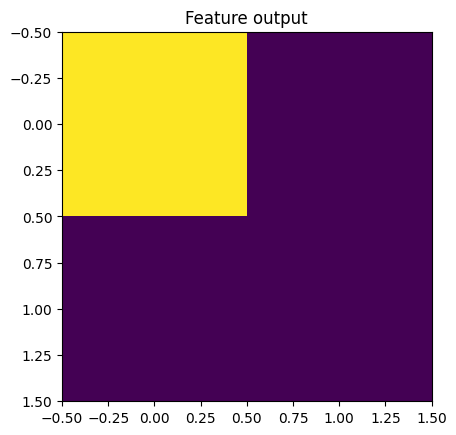

In [4]:
from deeptrack.features import Feature 

class DummyFeature(Feature):
    
    __distributed__ = False
    
    def get(self, image, **kwargs):
        print("I am a very slow feature...")
        output = np.zeros((2, 2, 1))
        output[0, 0] = 1
        return output

slow_feature = DummyFeature()

output_1 = slow_feature.resolve()

plt.imshow(output_1[..., 0])
plt.title("Feature output")
plt.show()

Now we apply the `FlipLR` augmentation, setting `p=0.5`, where `p` is the probability of flipping the image.

I am a very slow feature...

Applying FlipLR augmentation with probability 0.5.
Image flipped left-right.


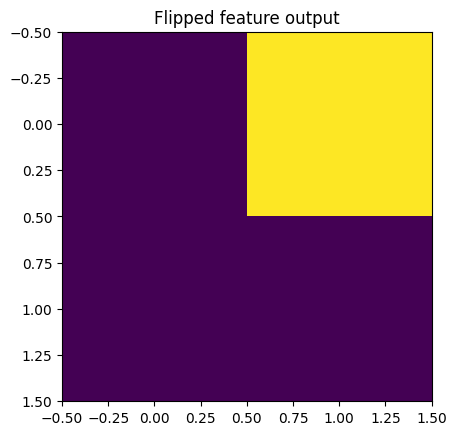

In [5]:
augmented_feature = slow_feature >> FlipLR(p=0.5)
augmented_feature.update()
output_2 = augmented_feature.resolve()

plt.imshow(output_2[..., 0])
plt.title("Flipped feature output")
plt.show()

## 4. Reusing Feature Outputs

To avoid redundant computations, `dt.Reuse` caches the outputs of a feature and reuses them multiple times before re-evaluating. This is particularly useful when working with augmentations since it allows multiple variations of the same feature output to be generated without having to recompute the underlying feature.

The example below shows how `dt.Reuse` can be used to avoid recomputing a slow feature while still applying augmentations efficiently.

In [6]:
import random

from deeptrack.image import Image

class Reuse(Feature):
    """Acts like cache.

    `Reuse` stores the output of a feature and reuses it for subsequent calls,
    even if it is updated. This is can be used after a time-consuming feature
    to augment the output of the feature without recalculating it.

    Parameters
    ----------
    feature: Feature
       The feature to reuse.
       
    uses: int
       Number of each stored image uses before evaluating `feature`.
       Note that the actual total number of uses is `uses * storage`.
       Should be constant.
       
    storage: int
       Number of instances of the output of `feature` to cache.
       Should be constant.

    """

    __distributed__ = False

    def __init__(
        self,
        feature: Feature,
        uses: int = 2,
        storage:int = 1,
        **kwargs
    ):
        super().__init__(uses=uses, storage=storage, **kwargs)
        self.feature = self.add_feature(feature)
        self.counter = 0
        self.cache = []

    def get(
        self,
        image,
        uses,
        storage,
        **kwargs
    ):
        """Abstract method which performs the `Reuse` augmentation."""

        self.cache = self.cache[-storage:]

        output = None

        if len(self.cache) < storage or self.counter % (uses * storage) == 0:
            print(f"Evaluating the feature...")
            output = self.feature(image)
            self.cache.append(output)
        else:
            print(f"Cache has enough stored values. Reusing a cached result.")
            output = random.choice(self.cache)

        self.counter += 1

        if not isinstance(output, list):
            output = [output]

        if not self._wrap_array_with_image:
            return output

        outputs = []
        for image in output:
            image_copy = Image(image)
            image_copy.properties = [prop.copy() for prop in image.properties]
            outputs.append(image_copy)

        return outputs

Here, we utilize the `Reuse` feature with `uses=3`, meaning that each cached output will be reused up to 3 times before the feature is re-evaluated. We also apply the `FlipLR` augmentation with a probability `p=0.5`, which means there is a 50% chance that the image will be flipped horizontally. The pipeline is resolved to produce the flipped image, as shown in the output.

Evaluating the feature...
I am a very slow feature...

Applying FlipLR augmentation with probability 0.5.
Image not flipped.


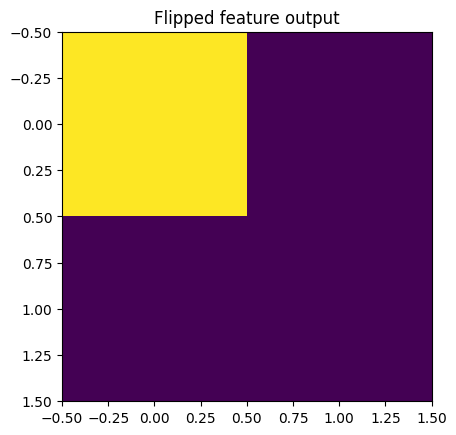

In [7]:
slow_feature = DummyFeature()

pipeline = Reuse(slow_feature, uses=3) >> FlipLR(p=0.5)

output_3 = pipeline.resolve()

plt.imshow(output_3[..., 0])
plt.title("Flipped feature output")
plt.show()

In the following loop, we update the pipeline multiple times, demonstrating how the feature is reused from the cache for the first two calls. For the third call, the feature will be recalculated as the cache is no longer valid after the specified number of uses. The augmentation is applied during each reuse, maintaining efficiency while still modifying the output.

Cache has enough stored values. Reusing a cached result.

Applying FlipLR augmentation with probability 0.5.
Image flipped left-right.


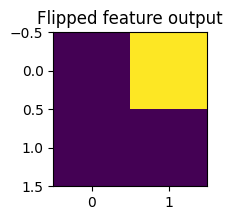

Cache has enough stored values. Reusing a cached result.

Applying FlipLR augmentation with probability 0.5.
Image not flipped.


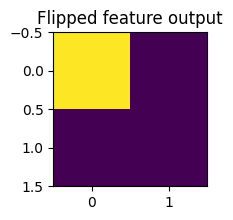

Evaluating the feature...
I am a very slow feature...

Applying FlipLR augmentation with probability 0.5.
Image not flipped.


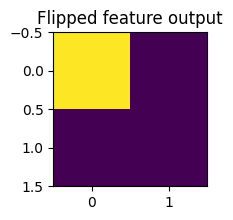

In [10]:
for i in range(3):
    pipeline.update()
    output_4 = pipeline.resolve()
    
    plt.figure(figsize=(2,2))
    plt.imshow(output_4[..., 0])
    plt.title("Flipped feature output")
    plt.show()

## 5. Augmenting Multiple Features Equally

It is not unusual to want to ensure several images are augmented in the same way. A common example is when creating an image-label pair using two different features, or the same feature resolved with different arguments. In the this case you can stack the inputs using the `&` operator.

Here will see how two identical features are augmented equally.

In [11]:
slow_feature_1 = DummyFeature()
slow_feature_2 = DummyFeature()

augmented_features = (slow_feature_1 & slow_feature_2) >> FlipLR()

I am a very slow feature...
I am a very slow feature...

Applying FlipLR augmentation with probability 0.5.
Image not flipped.

Applying FlipLR augmentation with probability 0.5.
Image not flipped.


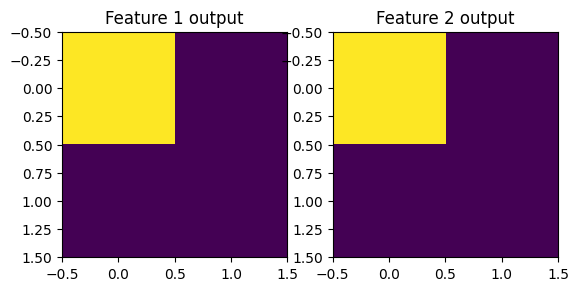

In [12]:
augmented_features.update()
output_1 = augmented_features.resolve()

plt.subplot(1, 2, 1)
plt.imshow(output_1[0][..., 0])
plt.title("Feature 1 output")
plt.subplot(1, 2, 2)
plt.imshow(output_1[1][..., 0])
plt.title("Feature 2 output")
plt.show()

I am a very slow feature...
I am a very slow feature...

Applying FlipLR augmentation with probability 0.5.
Image flipped left-right.

Applying FlipLR augmentation with probability 0.5.
Image flipped left-right.


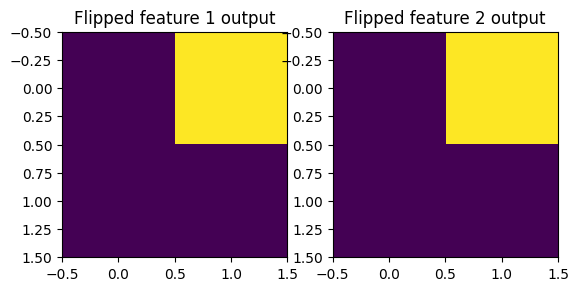

In [15]:
augmented_features.update()
output_2 = augmented_features.resolve()

plt.subplot(1, 2, 1)
plt.imshow(output_2[0][..., 0])
plt.title("Flipped feature 1 output")
plt.subplot(1, 2, 2)
plt.imshow(output_2[1][..., 0])
plt.title("Flipped feature 2 output")
plt.show()